## Simulação de uma LLM com memória da conversa (versão mais moderna do framework e com sumário de conversa)

ref.: 
* https://python.langchain.com/docs/how_to/message_history/
* https://www.langchain.com/langgraph
* https://langchain-ai.github.io/langgraph/how-tos/memory/add-summary-conversation-history/


In [1]:
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from typing import Literal
from IPython.display import Image, display

## Utilização do llama3.1 com interface via ollama

In [2]:
# Inicialize o modelo ChatOllama
llm = ChatOllama(model="llama3.1:latest")

# Adicione um `summary` ao estado além das mensagens
class State(MessagesState):
    summary: str

# Defina o gráfico de estados
workflow = StateGraph(state_schema=State)

# Função que chama o modelo
def call_model(state: State):
    # Adiciona um resumo se ele existir
    summary = state.get("summary", "")
    if summary:
        system_message = f"Resumo da conversa anterior: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": [response]}

# Função que decide quando resumir a conversa
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    if len(state["messages"]) > 6:  # Se mais de 6 mensagens, sumarizar
        return "summarize_conversation"
    return END

# Função que realiza o resumo da conversa
def summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"Este é o resumo da conversa até o momento: {summary}\n\n"
            "Estenda o resumo considerando as novas mensagens acima:"
        )
    else:
        summary_message = "Crie um resumo da conversa acima:"
    
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Exclui mensagens antigas, mantendo apenas as últimas duas
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Configuração do gráfico de estados
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")

workflow.add_conditional_edges(
    "conversation",
    should_continue,
)

workflow.add_edge("summarize_conversation", END)

# Inicialize a memória
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# Função para exibir as atualizações
def print_update(update):
    for k, v in update.items():
        for m in v["messages"]:
            m.pretty_print()
        if "summary" in v:
            print(v["summary"])

# Configuração de thread
config = {"configurable": {"thread_id": "abc123"}}

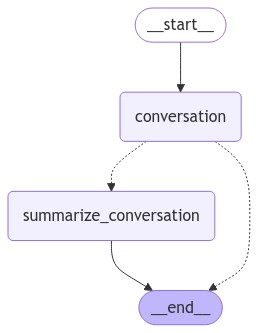

In [3]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Pergunta para iniciar a conversa

In [4]:
config = {"configurable": {"thread_id": "abc123"}}

query = "Quem foi Albert Einstein?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Quem foi Albert Einstein?
================================== Ai Message ==================================

Um físico alemão que ficou mundialmente conhecido por desenvolver a teoria da relatividade. Ele também fez contribuições significativas para o desenvolvimento do quantum e nas suas interpretações, principalmente na mecanica quântica.


In [5]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Quem foi Albert Einstein?', additional_kwargs={}, response_metadata={}, id='a2a7fdd3-fb69-43e3-be66-3697ed817b51'),
  AIMessage(content='Um físico alemão que ficou mundialmente conhecido por desenvolver a teoria da relatividade. Ele também fez contribuições significativas para o desenvolvimento do quantum e nas suas interpretações, principalmente na mecanica quântica.', additional_kwargs={}, response_metadata={'model': 'llama3.1:latest', 'created_at': '2024-10-05T16:46:54.60796194Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 3021800651, 'load_duration': 29772047, 'prompt_eval_count': 16, 'prompt_eval_duration': 118053000, 'eval_count': 56, 'eval_duration': 2608818000}, id='run-7960c2ac-c931-40f0-8b71-b35b66496515-0', usage_metadata={'input_tokens': 16, 'output_tokens': 56, 'total_tokens': 72})]}

## O modelo consegue se lembrar do que acabou de responder

In [6]:
query = "O que você disse?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

O que você disse?
================================== Ai Message ==================================

Eu disse que Albert Einstein foi um físico alemão famoso por ter desenvolvido a teoria da relatividade e ter feito contribuições importantes para o campo da física, incluindo o estudo do quantum e da mecânica quântica. Ele é considerado um dos cientistas mais influentes do século XX!


In [7]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Quem foi Albert Einstein?', additional_kwargs={}, response_metadata={}, id='a2a7fdd3-fb69-43e3-be66-3697ed817b51'),
  AIMessage(content='Um físico alemão que ficou mundialmente conhecido por desenvolver a teoria da relatividade. Ele também fez contribuições significativas para o desenvolvimento do quantum e nas suas interpretações, principalmente na mecanica quântica.', additional_kwargs={}, response_metadata={'model': 'llama3.1:latest', 'created_at': '2024-10-05T16:46:54.60796194Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 3021800651, 'load_duration': 29772047, 'prompt_eval_count': 16, 'prompt_eval_duration': 118053000, 'eval_count': 56, 'eval_duration': 2608818000}, id='run-7960c2ac-c931-40f0-8b71-b35b66496515-0', usage_metadata={'input_tokens': 16, 'output_tokens': 56, 'total_tokens': 72}),
  HumanMessage(content='O que você disse?', additional_kwargs={}, response_metadata={}, id='d927

In [8]:
query = "O que você disse? Ainda não consegui entender"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

O que você disse? Ainda não consegui entender
================================== Ai Message ==================================

Não se preocupe!

Vou explicar melhor:

Albert Einstein foi um cientista famoso que viveu no século 20. Ele era físico, o que significa que estudava a ciência da física.

Ele é conhecido por ter desenvolvido uma teoria chamada "teoria da relatividade", que mudou a forma como as pessoas entendem o tempo e o espaço.

Imagine que você está em um trem, viajando a 100 km/h. Você lança uma bola para cima no ar. Qual é a sua impressão sobre a velocidade com que a bola subiu? Provavelmente, você diria que ela subiu normalmente, como se estivesse parado no chão.

Mas, segundo Einstein, isso não está correto! Devido à velocidade do trem, o tempo passa um pouco mais devagar para você em relação ao observador externo. Isso pode parecer um absurdo, mas é exatamente o que a teoria da relativid

In [9]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Quem foi Albert Einstein?', additional_kwargs={}, response_metadata={}, id='a2a7fdd3-fb69-43e3-be66-3697ed817b51'),
  AIMessage(content='Um físico alemão que ficou mundialmente conhecido por desenvolver a teoria da relatividade. Ele também fez contribuições significativas para o desenvolvimento do quantum e nas suas interpretações, principalmente na mecanica quântica.', additional_kwargs={}, response_metadata={'model': 'llama3.1:latest', 'created_at': '2024-10-05T16:46:54.60796194Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 3021800651, 'load_duration': 29772047, 'prompt_eval_count': 16, 'prompt_eval_duration': 118053000, 'eval_count': 56, 'eval_duration': 2608818000}, id='run-7960c2ac-c931-40f0-8b71-b35b66496515-0', usage_metadata={'input_tokens': 16, 'output_tokens': 56, 'total_tokens': 72}),
  HumanMessage(content='O que você disse?', additional_kwargs={}, response_metadata={}, id='d927

In [10]:
query = "Nasceu onde?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Nasceu onde?
================================== Ai Message ==================================

Albert Einstein nasceu em Ulm, na Alemanha, em 14 de março de 1879.
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


Aqui está um resumo da nossa conversa:

* Eu apresentei Albert Einstein como um físico alemão famoso por ter desenvolvido a teoria da relatividade.
* Eu expliquei que ele é conhecido por suas contribuições importantes para o campo da física, incluindo o est

In [11]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Nasceu onde?', additional_kwargs={}, response_metadata={}, id='10341107-9366-4e45-b289-996d113fb622'),
  AIMessage(content='Albert Einstein nasceu em Ulm, na Alemanha, em 14 de março de 1879.', additional_kwargs={}, response_metadata={'model': 'llama3.1:latest', 'created_at': '2024-10-05T16:47:13.309688199Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 1757199171, 'load_duration': 67215859, 'prompt_eval_count': 457, 'prompt_eval_duration': 150317000, 'eval_count': 25, 'eval_duration': 1177944000}, id='run-d2de4768-5426-4196-8413-86bff17da668-0', usage_metadata={'input_tokens': 457, 'output_tokens': 25, 'total_tokens': 482})],
 'summary': 'Aqui está um resumo da nossa conversa:\n\n* Eu apresentei Albert Einstein como um físico alemão famoso por ter desenvolvido a teoria da relatividade.\n* Eu expliquei que ele é conhecido por suas contribuições importantes para o campo da física, incluindo o 

In [12]:
query = "Quando é o aniversário dele?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Quando é o aniversário dele?
================================== Ai Message ==================================

O aniversário do Albert Einstein é em 14 de março! (1879)


In [13]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Nasceu onde?', additional_kwargs={}, response_metadata={}, id='10341107-9366-4e45-b289-996d113fb622'),
  AIMessage(content='Albert Einstein nasceu em Ulm, na Alemanha, em 14 de março de 1879.', additional_kwargs={}, response_metadata={'model': 'llama3.1:latest', 'created_at': '2024-10-05T16:47:13.309688199Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 1757199171, 'load_duration': 67215859, 'prompt_eval_count': 457, 'prompt_eval_duration': 150317000, 'eval_count': 25, 'eval_duration': 1177944000}, id='run-d2de4768-5426-4196-8413-86bff17da668-0', usage_metadata={'input_tokens': 457, 'output_tokens': 25, 'total_tokens': 482}),
  HumanMessage(content='Quando é o aniversário dele?', additional_kwargs={}, response_metadata={}, id='67eb24ea-cecc-4ed5-a82b-479e3ead8532'),
  AIMessage(content='O aniversário do Albert Einstein é em 14 de março! (1879)', additional_kwargs={}, response_metadata={'model

In [14]:
query = "O que você disse por último?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

O que você disse por último?
================================== Ai Message ==================================

Nada, foi apenas uma afirmação sobre a data do nascimento de Einstein. Nossa conversa começou com um resumo falso e não houve conversa anterior real para referenciar. Se quiseres saber algo específico sobre Einstein ou qualquer outra coisa, estou aqui para ajudar!


In [15]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Nasceu onde?', additional_kwargs={}, response_metadata={}, id='10341107-9366-4e45-b289-996d113fb622'),
  AIMessage(content='Albert Einstein nasceu em Ulm, na Alemanha, em 14 de março de 1879.', additional_kwargs={}, response_metadata={'model': 'llama3.1:latest', 'created_at': '2024-10-05T16:47:13.309688199Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 1757199171, 'load_duration': 67215859, 'prompt_eval_count': 457, 'prompt_eval_duration': 150317000, 'eval_count': 25, 'eval_duration': 1177944000}, id='run-d2de4768-5426-4196-8413-86bff17da668-0', usage_metadata={'input_tokens': 457, 'output_tokens': 25, 'total_tokens': 482}),
  HumanMessage(content='Quando é o aniversário dele?', additional_kwargs={}, response_metadata={}, id='67eb24ea-cecc-4ed5-a82b-479e3ead8532'),
  AIMessage(content='O aniversário do Albert Einstein é em 14 de março! (1879)', additional_kwargs={}, response_metadata={'model

In [16]:
query = "Qual foi a maior contribuição dele?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Qual foi a maior contribuição dele?
================================== Ai Message ==================================

A maior contribuição de Albert Einstein é considerada ser a sua teoria da relatividade, que revolucionou a física e mudou nossa compreensão do tempo e do espaço. A teoria dividida em duas partes:

1. **Relatividade Restrita** (1905): Explicou como o tempo e o espaço são afetados pela velocidade e pela gravidade. Mostrou que o tempo e o espaço não são absolutos, mas dependem do observador.
2. **Relatividade Geral** (1915): Desenvolveu uma teoria mais completa da gravidade, demonstrando que a gravidade é uma curvatura no espaço-tempo causada pela presença de massa.

Essa contribuição revolucionou a física e abriu caminhos para avanços em outras áreas como a cosmologia, a astrofísica e a medicina. Além disso, Einstein também fez contribuições importantes na área do quantum e da mecânica quânt

In [17]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Qual foi a maior contribuição dele?', additional_kwargs={}, response_metadata={}, id='cf985627-8938-4de8-9514-8461f2f131c7'),
  AIMessage(content='A maior contribuição de Albert Einstein é considerada ser a sua teoria da relatividade, que revolucionou a física e mudou nossa compreensão do tempo e do espaço. A teoria dividida em duas partes:\n\n1. **Relatividade Restrita** (1905): Explicou como o tempo e o espaço são afetados pela velocidade e pela gravidade. Mostrou que o tempo e o espaço não são absolutos, mas dependem do observador.\n2. **Relatividade Geral** (1915): Desenvolveu uma teoria mais completa da gravidade, demonstrando que a gravidade é uma curvatura no espaço-tempo causada pela presença de massa.\n\nEssa contribuição revolucionou a física e abriu caminhos para avanços em outras áreas como a cosmologia, a astrofísica e a medicina. Além disso, Einstein também fez contribuições importantes na área do quantum e da mecânica quântica.\n\nMas 

In [18]:
query = "O que você disse por último?"
input_message = HumanMessage(content=query)
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

O que você disse por último?
================================== Ai Message ==================================

Eu disse que a maior contribuição de Albert Einstein foi a sua teoria da relatividade!


In [19]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Qual foi a maior contribuição dele?', additional_kwargs={}, response_metadata={}, id='cf985627-8938-4de8-9514-8461f2f131c7'),
  AIMessage(content='A maior contribuição de Albert Einstein é considerada ser a sua teoria da relatividade, que revolucionou a física e mudou nossa compreensão do tempo e do espaço. A teoria dividida em duas partes:\n\n1. **Relatividade Restrita** (1905): Explicou como o tempo e o espaço são afetados pela velocidade e pela gravidade. Mostrou que o tempo e o espaço não são absolutos, mas dependem do observador.\n2. **Relatividade Geral** (1915): Desenvolveu uma teoria mais completa da gravidade, demonstrando que a gravidade é uma curvatura no espaço-tempo causada pela presença de massa.\n\nEssa contribuição revolucionou a física e abriu caminhos para avanços em outras áreas como a cosmologia, a astrofísica e a medicina. Além disso, Einstein também fez contribuições importantes na área do quantum e da mecânica quântica.\n\nMas 